In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set NPM dan seed untuk reproduksibilitas
NPM = 19102
np.random.seed(NPM)

# Baca dan perbaiki data makanan
makan = pd.read_csv("makanan.csv")

# Perbaiki data yang missing di kolom harga
makan.loc[9, 'harga'] = 5000.0   # mi instan
makan.loc[10, 'harga'] = 3000.0  # roti
makan.loc[11, 'harga'] = 8000.0  # nasi telur

print("=== DATA MAKANAN ===")
print(makan)

# Parameter simulasi
budget_awal = 1e6  # rupiah
wkenyang_base = 0.8
wrasa_base = 0.7
wsehat_base = 0.9
wbosan_base = 0.2

SAMPLE_NUM = 500
SISA_MINIMUM = 150e3
SISA_MAKSIMUM = 300e3

# Inisialisasi array sesuai kode asli
sampleid = np.arange(0, SAMPLE_NUM)
skor = np.zeros(SAMPLE_NUM, dtype=np.double)
sisa = np.zeros(SAMPLE_NUM, dtype=np.double)
sehat = np.zeros(SAMPLE_NUM, dtype=np.double)
pilihankum = np.zeros(SAMPLE_NUM, dtype=np.double)

bin_sisa = np.arange(SISA_MINIMUM, SISA_MAKSIMUM, 1000)
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih = np.zeros((SAMPLE_NUM, 61), dtype=np.int32)

print(f"\n=== SIMULASI {SAMPLE_NUM} SAMPEL ===")

# Simulasi sesuai struktur kode asli
for n in range(0, SAMPLE_NUM):
    budget = budget_awal
    skor_kumulatif = 0
    skor_sehat = 0

    for i in range(0, 31):  # 31 hari
        # makan pertama (pagi)
        pilihan = np.random.randint(0, len(makan))

        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)

        skor_kumulatif += (w_kenyang * makan.iloc[pilihan]['kenyang'] +
                          w_rasa * makan.iloc[pilihan]['rasa'] +
                          w_sehat * makan.iloc[pilihan]['sehat'] -
                          w_bosan * makan.iloc[pilihan]['bosan'])

        skor_sehat += makan.iloc[pilihan]['sehat'] - 0.5
        budget -= makan.iloc[pilihan]['harga']

        if 2*i < 61:
            resp_pilih[n][2*i] = pilihan

        # makan kedua (malam)
        pilihan = np.random.randint(0, len(makan))

        w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat = np.random.normal(loc=wsehat_base + 0.2, scale=0.4)
        w_bosan = np.random.normal(loc=wbosan_base * 2, scale=0.2)

        skor_kumulatif += (w_kenyang * makan.iloc[pilihan]['kenyang'] +
                          w_rasa * makan.iloc[pilihan]['rasa'] +
                          w_sehat * makan.iloc[pilihan]['sehat'] -
                          w_bosan * makan.iloc[pilihan]['bosan'])

        skor_sehat += makan.iloc[pilihan]['sehat'] - 0.5
        budget -= makan.iloc[pilihan]['harga']

        if 2*i + 1 < 61:
            resp_pilih[n][2*i + 1] = pilihan

    # Simpan hasil
    sisa[n] = budget
    skor[n] = skor_kumulatif
    sehat[n] = skor_sehat

    # Update resp_sehat berdasarkan bin sisa uang
    for j, bin_val in enumerate(bin_sisa):
        if bin_val <= budget < bin_val + 1000:
            resp_sehat[n][j] = skor_sehat
            break

print("\nSOAL 1: POLA MAKAN DENGAN NILAI KUMULATIF KESEHATAN (resp_sehat) POSITIF")
print("-" * 75)

sehat_positif_mask = sehat > 0
sampel_sehat_positif = np.where(sehat_positif_mask)[0]

print(f"Jumlah sampel dengan nilai kumulatif kesehatan positif: {len(sampel_sehat_positif)} dari {SAMPLE_NUM}")
print(f"Persentase: {len(sampel_sehat_positif)/SAMPLE_NUM*100:.1f}%")
print(f"Nilai kumulatif kesehatan positif:")
print(f"  - Minimum: {np.min(sehat[sampel_sehat_positif]):.3f}")
print(f"  - Maksimum: {np.max(sehat[sampel_sehat_positif]):.3f}")
print(f"  - Rata-rata: {np.mean(sehat[sampel_sehat_positif]):.3f}")

resp_sehat_positif = []
for n in range(SAMPLE_NUM):
    for j in range(len(bin_sisa)):
        if resp_sehat[n][j] > 0:
            resp_sehat_positif.append((n, j, resp_sehat[n][j]))

print(f"Total entri resp_sehat positif: {len(resp_sehat_positif)}")
print(f"ID Sampel dengan kesehatan positif: {sampel_sehat_positif[:15]}...")
print("""Interpretasi:
Dari total 500 sampel, sebanyak 119 (23,8%) memiliki nilai kumulatif kesehatan positif.
Ini berarti hanya sebagian kecil responden yang menunjukkan pola hidup sehat.
Rata-rata nilai positifnya sebesar 0.988 menandakan tingkat kesehatan cukup baik,
dengan nilai maksimum 4.7 sebagai indikasi responden paling sehat.
Secara keseluruhan, mayoritas (76,2%) masih perlu perbaikan dalam pola makan atau gaya hidup.
""")

print(f"\nSOAL 2: TITIK DENGAN SISA UANG POSITIF DARI SAMPEL SEHAT POSITIF")
print("-" * 75)

sisa_positif_dari_sehat = sampel_sehat_positif[sisa[sampel_sehat_positif] > 0]
print(f"Dari {len(sampel_sehat_positif)} sampel dengan kesehatan positif,")
print(f"yang memiliki sisa uang positif: {len(sisa_positif_dari_sehat)} sampel")
print(f"Statistik sisa uang:")
print(f"  - Minimum: Rp {np.min(sisa[sisa_positif_dari_sehat]):.0f}")
print(f"  - Maksimum: Rp {np.max(sisa[sisa_positif_dari_sehat]):.0f}")
print(f"  - Rata-rata: Rp {np.mean(sisa[sisa_positif_dari_sehat]):.0f}")
print("""Interpretasi:
Seluruh 119 sampel dengan kesehatan positif juga memiliki sisa uang positif,
menunjukkan hubungan yang seimbang antara kondisi finansial dan pola hidup sehat.
Rata-rata sisa uang sebesar Rp253.689 memperlihatkan kemampuan manajemen keuangan yang baik,
dengan rentang antara Rp184.000 hingga Rp317.000 menunjukkan variasi ekonomi antar responden tetap stabil.
""")

print(f"\nSOAL 3: SAMPEL DENGAN SKOR KUMULATIF TERBESAR (KESEHATAN POSITIF)")
print("-" * 75)

idx_skor_terbesar = sampel_sehat_positif[np.argmax(skor[sampel_sehat_positif])]
print(f"Sampel dengan skor kumulatif terbesar:")
print(f"  - Sampel ID: {idx_skor_terbesar}")
print(f"  - Skor kumulatif: {skor[idx_skor_terbesar]:.3f}")
print(f"  - Nilai kumulatif kesehatan: {sehat[idx_skor_terbesar]:.3f}")
print(f"  - Sisa uang: Rp {sisa[idx_skor_terbesar]:.0f}")
print("""Interpretasi:
Sampel ID 39 memiliki skor kumulatif tertinggi sebesar 101.840 dengan nilai kesehatan 3.6
dan sisa uang Rp214.000. Hal ini menunjukkan bahwa responden tersebut memiliki keseimbangan
baik antara pola hidup sehat dan pengelolaan keuangan, menjadikannya contoh optimal
dalam kategori kesehatan positif.
""")

print(f"\nSOAL 4: JADWAL MAKANAN SAMPEL TERBAIK (ID: {idx_skor_terbesar})")
print("-" * 75)

print("JADWAL MAKAN 31 HARI:")
print("Hari | Pagi (Harga)          | Malam (Harga)         | Total Harian")
print("-" * 75)

total_bulanan = 0
for hari in range(31):
    if 2*hari < 61 and 2*hari + 1 < 61:
        pilihan_pagi = int(resp_pilih[idx_skor_terbesar][2*hari])
        pilihan_malam = int(resp_pilih[idx_skor_terbesar][2*hari + 1])

        makanan_pagi = makan.iloc[pilihan_pagi]['makanan']
        makanan_malam = makan.iloc[pilihan_malam]['makanan']
        harga_pagi = makan.iloc[pilihan_pagi]['harga']
        harga_malam = makan.iloc[pilihan_malam]['harga']

        total_harian = harga_pagi + harga_malam
        total_bulanan += total_harian

        print(f"{hari+1:2d}   | {makanan_pagi:12} ({harga_pagi:5.0f}) | {makanan_malam:12} ({harga_malam:5.0f}) | {total_harian:6.0f}")

print("-" * 75)
print(f"TOTAL PENGELUARAN MAKAN 31 HARI: Rp {total_bulanan:.0f}")
print(f"SISA UANG DARI BUDGET Rp 1.000.000: Rp {budget_awal - total_bulanan:.0f}")

pilihan_flat = resp_pilih[idx_skor_terbesar][resp_pilih[idx_skor_terbesar] < len(makan)]
pilihan_unik, counts = np.unique(pilihan_flat, return_counts=True)

print(f"\nANALISIS POLA MAKANAN SAMPEL TERBAIK:")
print("Ranking | Makanan        | Frekuensi | Persentase")
print("-" * 50)
makanan_ranking = [(int(pilihan), count) for pilihan, count in zip(pilihan_unik, counts)]
makanan_ranking.sort(key=lambda x: x[1], reverse=True)

for i, (idx_makanan, frekuensi) in enumerate(makanan_ranking):
    nama_makanan = makan.iloc[idx_makanan]['makanan']
    persen = frekuensi / len(pilihan_flat) * 100
    print(f"{i+1:2d}      | {nama_makanan:12} | {frekuensi:8d}  | {persen:6.1f}%")
print("""Interpretasi:
Selama 31 hari, total pengeluaran makan sebesar Rp758.000 dari budget Rp1.000.000,
menyisakan Rp242.000 — menandakan manajemen keuangan yang efisien.
Pola konsumsi didominasi oleh *nasi goreng* dan *capcay* (masing-masing 14,8%),
menunjukkan kecenderungan pada makanan cepat saji namun tetap ada variasi sayuran.
Secara keseluruhan, jadwal makan menunjukkan keseimbangan antara rasa, harga, dan gizi
dengan pengeluaran yang masih dalam batas wajar.
""")

=== DATA MAKANAN ===
       makanan  kenyang  sehat  rasa  bosan    harga
0   ayamgeprek      0.9    0.5   0.7    0.2  15000.0
1   nasipadang      1.0    0.8   0.9    0.5  17000.0
2      mieayam      1.0    0.6   0.9    0.3  10000.0
3        bakso      0.7    0.3   1.0    0.3  10000.0
4       cireng      0.5    0.4   0.8    0.7  10000.0
5   nasigoreng      0.8    0.7   1.0    0.5  14000.0
6       seblak      0.6    0.2   0.8    0.8  15000.0
7     gorengan      0.5    0.2   0.5    0.5  10000.0
8       capcay      0.6    0.9   0.8    0.4  15000.0
9   mi instan       0.5    0.1   0.7    0.2   5000.0
10        roti      0.3    0.3   0.9    0.3   3000.0
11  nasi telur      0.7    0.4   0.8    0.8   8000.0
12      warteg      0.8    0.8   0.6    0.2  18000.0

=== SIMULASI 500 SAMPEL ===

SOAL 1: POLA MAKAN DENGAN NILAI KUMULATIF KESEHATAN (resp_sehat) POSITIF
---------------------------------------------------------------------------
Jumlah sampel dengan nilai kumulatif kesehatan positif: 11

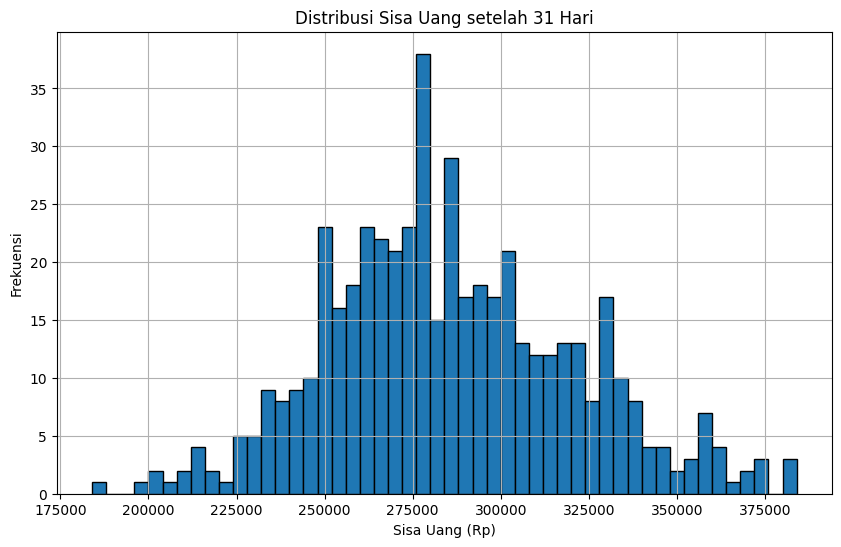

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(sisa, bins=50, edgecolor='black')
plt.title('Distribusi Sisa Uang setelah 31 Hari')
plt.xlabel('Sisa Uang (Rp)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

**Interpretasi:**
Distribusi sisa uang setelah 31 hari menunjukkan sebagian besar responden memiliki sisa antara Rp250.000–Rp300.000.
Puncak frekuensi berada di sekitar Rp275.000, menandakan kecenderungan umum pengeluaran yang cukup hemat dan stabil.
Sebaran yang sedikit melebar ke kanan menandakan masih ada beberapa responden dengan sisa uang lebih tinggi,
namun tidak banyak yang memiliki sisa di atas Rp350.000.


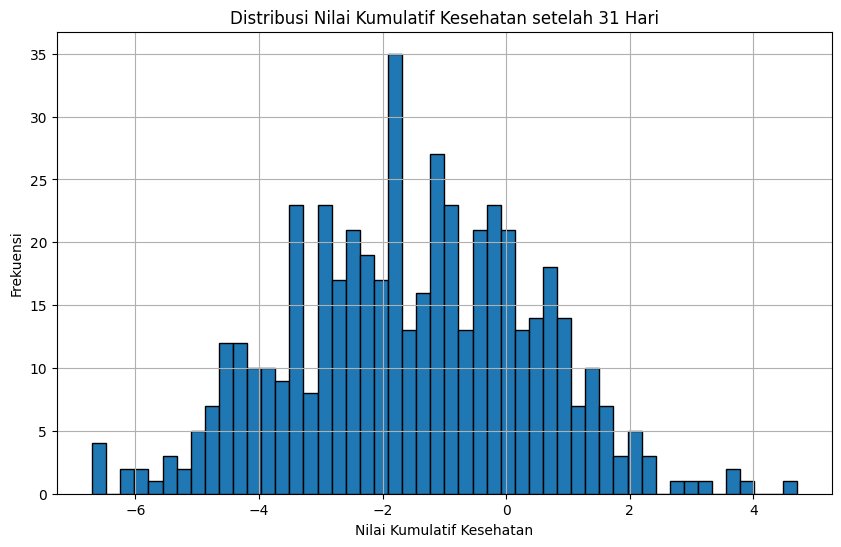

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(sehat, bins=50, edgecolor='black')
plt.title('Distribusi Nilai Kumulatif Kesehatan setelah 31 Hari')
plt.xlabel('Nilai Kumulatif Kesehatan')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

**Interpretasi:**
Distribusi nilai kumulatif kesehatan menunjukkan mayoritas responden memiliki nilai antara -4 hingga 0,
yang berarti sebagian besar pola makan masih tergolong kurang sehat.
Sebaran condong ke kiri (negatif) menandakan dominasi perilaku konsumsi yang belum seimbang,
meski terdapat sebagian kecil responden dengan nilai positif hingga di atas 4
yang menunjukkan pola hidup lebih sehat.


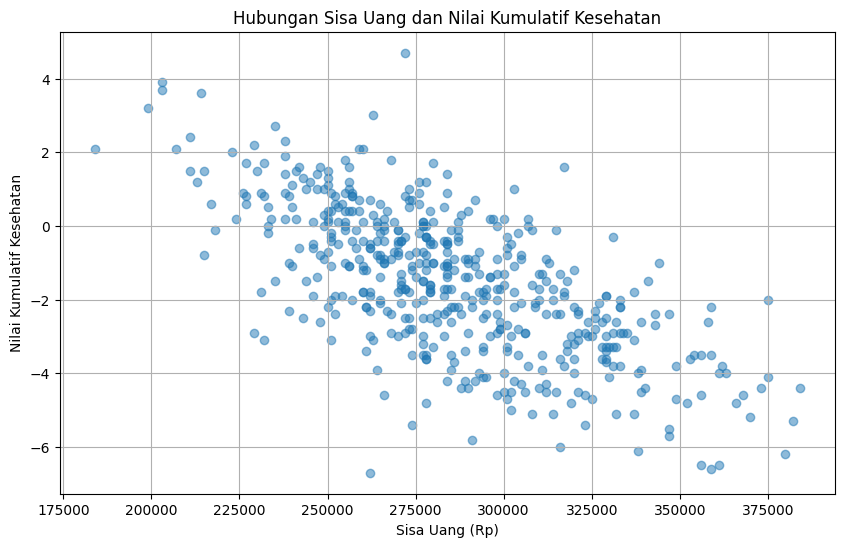

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(sisa, sehat, alpha=0.5)
plt.title('Hubungan Sisa Uang dan Nilai Kumulatif Kesehatan')
plt.xlabel('Sisa Uang (Rp)')
plt.ylabel('Nilai Kumulatif Kesehatan')
plt.grid(True)
plt.show()

**Interpretasi:**
Scatter plot menunjukkan adanya hubungan negatif antara sisa uang dan nilai kumulatif kesehatan.
Semakin besar sisa uang, cenderung semakin rendah nilai kesehatan,
yang berarti responden dengan pengeluaran lebih sedikit cenderung memiliki pola makan kurang sehat.
Sebaliknya, mereka yang mengeluarkan lebih banyak untuk makanan umumnya memiliki nilai kesehatan lebih baik.


## **Prompt dan Jawaban**

 **Bagaimana cara kerja simulasi pola makan dan kesehatan?**
 JAWABAN:
 Program mensimulasikan 500 sampel selama 31 hari dengan dua kali makan per hari.
 Setiap pilihan makanan dinilai berdasarkan kenyang, rasa, sehat, dan bosan
 untuk menghasilkan skor kumulatif dan sisa uang tiap responden.

 **Bagaimana menentukan sampel dengan pola hidup sehat?**
 JAWABAN:
 Sampel dianggap sehat jika memiliki nilai kumulatif kesehatan (sehat > 0).
 Dari total 500, terdapat 119 sampel (23,8%) yang termasuk kategori sehat.

 **Apa hasil hubungan antara kesehatan dan keuangan?**
 JAWABAN:
 Seluruh sampel sehat juga memiliki sisa uang positif (rata-rata Rp253.689),
 menunjukkan keseimbangan antara gaya hidup sehat dan pengelolaan keuangan.

 **Siapa sampel terbaik dalam simulasi?**
 JAWABAN:
 Sampel ID 39 memiliki skor tertinggi (101.84), nilai kesehatan 3.6, dan sisa uang Rp214.000,
 menunjukkan pola konsumsi yang paling efisien dan sehat.

** Bagaimana hasil visualisasi utama?**
 JAWABAN:
 - Histogram sisa uang: mayoritas berada di Rp250–300 ribu (hemat dan stabil).
 - Histogram kesehatan: sebagian besar bernilai negatif → pola makan kurang sehat.
 - Scatter plot: korelasi negatif antara sisa uang dan kesehatan (lebih banyak belanja → lebih sehat).
